In [1]:
# basic stuff
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import files
import os
import sklearn

# dim reduction and visualization
from sklearn.decomposition import PCA
# !pip install umap
# !pip install umap-learn
# import umap.umap_ as umap
from sklearn.manifold import TSNE

# torch stuff
# !pip install
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get Data

The csvs are structured as so:

* Each trial is one row (160 rows/trials for each csv)
* Each trial has a different number of timestamps - some trials take longer than others
* The number of columns is determined by the trial with the max number of timestamps in that session
* The number of columns equals: max_timestamps*(gloveinput_dim+neuraloutput_dim+cursor_dim+timestamp_dim)
* The longest trial has no null values, all other trials have null values where they have no timestamps (the shorter, the more null values)

I restructured the data in the following way:

* For each trial (i.e. each row), I got rid of all null values. Then I extracted each of the data types (glove, neural, etc) separately, and reshaped them to dim x num_timestamps, where dim is the dimensionality of that particular data type.

In [3]:
# get data from each session - 16,17,18,19
# csvs were obtained from matlab object (code in matlab)
trialdata16 = np.genfromtxt('trialdata16.csv', delimiter = ',')[1:,1:]
trialdata17 = np.genfromtxt('trialdata17.csv', delimiter = ',')[1:,1:]
trialdata18 = np.genfromtxt('trialdata18.csv', delimiter = ',')[1:,1:]
trialdata19 = np.genfromtxt('trialdata19.csv', delimiter = ',')[1:,1:]

In [4]:
trialdata16.shape, trialdata17.shape, trialdata18.shape, trialdata19.shape

((160, 65132), (160, 62811), (160, 36582), (160, 25350))

In [5]:
# number of timestamps for each trial; 160 trials
# timestamps obtained by copying and pasting size of timestamps - not sure how to extract from MatlabOpaque object...
timestamps_list16 = [72,47,81,52,73,46,69,116,102,52,55,60,58,49,112,42,61,37,64,58,47,53,55,46,42,40,76,35,60,52,53,49,51,51,57,48,138,35,77,70,87,46,53,857,57,37,67,37,48,43,48,368,135,44,61,40,44,45,54,46,45,47,54,69,201,67,64,40,55,65,49,44,92,62,51,37,51,46,38,41,57,46,72,65,87,56,69,50,66,39,115,70,57,71,60,40,67,115,96,123,45,40,49,40,193,154,56,67,49,48,137,53,79,59,93,43,53,43,71,74,50,39,80,69,42,39,59,237,56,50,39,42,56,45,51,41,37,52,78,25,130,71,66,47,68,71,72,56,60,63,70,58,62,116,51,101,58,60,48,47]
timestamps_list17 = [61,103,51,131,60,84,46,142,122,37,62,80,41,45,55,52,52,39,135,41,198,56,71,78,52,172,51,52,180,43,168,73,44,40,51,63,51,37,74,55,52,35,57,59,48,38,51,53,60,40,52,265,52,53,68,41,49,60,53,46,53,33,43,50,51,36,72,28,50,40,50,48,62,45,46,58,58,31,54,110,69,88,44,43,56,80,52,40,46,49,44,35,61,48,67,39,65,27,54,50,190,139,74,39,53,52,68,43,47,117,91,36,71,49,57,119,65,94,56,41,42,46,55,205,99,22,60,34,57,47,111,42,58,53,185,454,50,37,67,41,68,33,33,62,56,44,54,42,60,49,55,36,50,42,39,57,182,997,50,51]
timestamps_list18 = [113,546,140,114,68,176,24,188,104,94,114,65,123,48,113,80,98,119,105,79,70,93,73,54,68,94,93,100,108,37,85,110,67,43,140,57,104,109,97,158,59,94,51,64,78,32,91,40,62,158,46,63,71,56,86,75,68,63,106,56,43,89,53,101,126,63,67,129,63,83,81,75,71,50,36,80,115,45,71,56,46,58,39,89,35,102,86,75,27,96,49,99,106,84,62,68,115,54,76,84,66,54,101,53,80,56,49,46,62,81,41,48,42,86,43,67,95,42,82,118,86,99,36,76,66,68,31,117,47,61,39,55,48,59,93,58,52,54,51,30,185,64,72,62,85,85,93,63,66,40,54,60,35,82,58,36,42,70,59,69]
timestamps_list19 = [61,236,63,67,68,71,105,105,62,62,77,34,67,60,68,48,66,155,78,43,104,120,82,310,71,53,61,53,71,98,64,93,83,36,69,37,49,55,42,47,71,53,109,74,56,507,67,32,130,60,46,45,63,41,115,185,47,253,110,52,96,42,191,137,48,50,56,52,193,165,88,58,33,216,31,65,56,39,71,59,190,89,57,64,85,56,110,65,65,82,82,34,52,90,86,61,56,73,38,85,83,50,53,137,38,49,48,54,101,44,181,46,78,46,52,87,57,108,185,26,46,112,63,54,130,37,115,126,57,76,56,129,65,80,55,64,101,36,36,45,162,55,74,38,185,110,59,155,35,54,88,58,42,71,63,42,175,62,74,68]
# shape of glove position array, neural output array, cursor position array, timestamp array
# only dimensionality of neural output array varies with each session
shapes_list16 = [19, 54, 2, 1]
shapes_list17 = [19, 41, 2, 1]
shapes_list18 = [19, 45, 2, 1]
shapes_list19 = [19, 28, 2, 1]
neuraloutputs_shapes_list = [54,41,45,28]

In [6]:
print(max(timestamps_list16), np.argmax(np.array(timestamps_list16)))

857 43


In [7]:
# def organize_trial_data(trialdata, timestamps_list, shapes_list):
#   # The purpose of this function is to extract all of the data from the csv for each session
#   # Each trial's data - including glove, neural, timestamp, and cursor data - is stored in one row
#   # This function extracts 
#     session_organized = []
#     neural_output_shape = shapes_list[1]
#     num_timestamps = max(timestamps_list)
#     print(num_timestamps)

#     for trial in trialdata:
#         trial[np.isnan(trial)] = 0

#         gloveinput = trial[:19*num_timestamps].reshape((19, num_timestamps), order = 'F')
#         neuraloutput = trial[19*num_timestamps:(19+neural_output_shape)*num_timestamps].reshape((neural_output_shape, num_timestamps), order = 'F')
#         cursorposition = trial[(19+neural_output_shape)*num_timestamps:(19+neural_output_shape+2)*num_timestamps].reshape((2, num_timestamps), order = 'F')
#         timestamps = trial[(19+neural_output_shape+2)*num_timestamps:]

#         # trial_sorted contains all of the data for each trial
#         # trial_sorted is a list of length 160, each element represents one trial
#         # each element is a tuple of length 4, containing gloveinput, neuraloutput, cursorposition, and timestamps
#         session_organized.append([gloveinput, neuraloutput, cursorposition, timestamps])

#     return(session_organized)

def organize_trial_data(trialdata, timestamps_list, shapes_list):
  # The purpose of this function is to extract all of the data from the csv for each session
  # Each trial's data - including glove, neural, timestamp, and cursor data - is stored in one row
  # This function extracts 
    session_organized = []
    neural_output_shape = shapes_list[1]

    for trial, num_timestamps in zip(trialdata, timestamps_list):
        new_data = trial[~np.isnan(trial)]

        gloveinput = new_data[:19*num_timestamps].reshape((19, num_timestamps), order = 'F')
        neuraloutput = new_data[19*num_timestamps:(19+neural_output_shape)*num_timestamps].reshape((neural_output_shape, num_timestamps), order = 'F')
        cursorposition = new_data[(19+neural_output_shape)*num_timestamps:(19+neural_output_shape+2)*num_timestamps].reshape((2, num_timestamps), order = 'F')
        timestamps = new_data[(19+neural_output_shape+2)*num_timestamps:]

        # trial_sorted contains all of the data for each trial
        # trial_sorted is a list of length 160, each element represents one trial
        # each element is a tuple of length 4, containing gloveinput, neuraloutput, cursorposition, and timestamps
        session_organized.append([gloveinput, neuraloutput, cursorposition, timestamps])

    return(session_organized)

In [8]:
sessions = [trialdata16, trialdata17, trialdata18, trialdata19]
sessions_timestamps = [timestamps_list16, timestamps_list17, timestamps_list18, timestamps_list19]
sessions_shapes = [shapes_list16, shapes_list17, shapes_list18, shapes_list19]
sessions_names = ['trialdata16', 'trialdata17', 'trialdata18', 'trialdata19']
sessions_organized = []

for session, timestamps_list, session_shape, name in zip(sessions, sessions_timestamps, sessions_shapes,sessions_names):
    print(name)
    sessions_organized.append(organize_trial_data(session, timestamps_list, session_shape))

trialdata16
trialdata17
trialdata18
trialdata19


In [9]:
# 4 sessions - 16, 17, 18, 19
len(sessions_organized)

4

In [10]:
# 160 trials per session
len(sessions_organized[0])

160

In [11]:
# 4 elements per session - glove, neural, cursor, timestamp
len(sessions_organized[0][0])

4

In [12]:
# the first trial's glove input (857 timestamps after padding)
sessions_organized[0][0][0].shape

(19, 72)

# Build Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, session_num, normalize_inputs = True, shuffle = False):
        if type(session_num == int):
            self.session_num = session_num
            s = session_num-16
            self.session = sessions_organized[s]
        elif type(session_num == list):
            s = [i-16 for i in session_num]
            self.session = sessions_organized[s]

        self.normalize_inputs = normalize_inputs
        self.gloveinputs = []
        self.neuraloutputs = []
        self.trialnums = []
        self.samplenums = []
        self.max_timestamps = 0
        self.input_max_val = 0

        for trialnum, trial in enumerate(self.session):
            if trial[0].shape[1] > self.max_timestamps:
                self.max_timestamps = trial[0].shape[1]
            if trial[0].max() > self.input_max_val:
                self.input_max_val = int(trial[0].max())
            self.gloveinputs.append(trial[0].T)
            self.neuraloutputs.append(trial[1].T)
            self.trialnums.append(trialnum)
            self.samplenums.append(np.arange(trial[0].shape[0]))

        def normalize_inputs(g):
            stacked = np.vstack(g)
            mean = np.mean(stacked, axis = 0)
            var = np.var(stacked, axis = 0)

            normalized_inputs = []
            for trial in self.gloveinputs:
                normalized = (trial-mean)/var
                normalized_inputs.append(normalized)

            return(normalized_inputs)

        def shuffle_data(g, n, t, sn):
            assert len(g) == len(n)
            assert len(g) == len(t)
            assert len(g) == len(sn)
            p = np.random.permutation(len(g))
            return(g[p], n[p], t[p], sn[p])

        self.gloveinputs_normalized = normalize_inputs(self.gloveinputs)

        if shuffle == True:
            self.gloveinputs, self.neuraloutputs, self.trialnums, self.samplenums = \
                shuffle_data(self.gloveinputs, self.neuraloutputs, self.trialnums, self.samplenums)
            

    def __len__(self):
        assert len(self.gloveinputs) == len(self.neuraloutputs)
        return len(self.gloveinputs)

    def __getitem__(self, idx):
        if self.normalize_inputs == True:
            gloveinput = torch.from_numpy(self.gloveinputs_normalized[idx])
        else:
            gloveinput = torch.from_numpy(self.gloveinputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        samplenum = self.samplenums[idx]
        trialnum = self.trialnums[idx]

        return gloveinput.float(), neuraloutput.float(), samplenum, trialnum, self.session_num

In [14]:
np.random.seed(1)

session16_dataset = CustomDataset(session_num = 16, normalize_inputs = True)#, shuffle = True)
session17_dataset = CustomDataset(session_num = 17, normalize_inputs = True)#, shuffle = True)
session18_dataset = CustomDataset(session_num = 18, normalize_inputs = True)#, shuffle = True)
session19_dataset = CustomDataset(session_num = 19, normalize_inputs = True)#, shuffle = True)

sessions_dataset_list = [session16_dataset, session17_dataset, session18_dataset, session19_dataset]

In [15]:
session16_dataset[0][0]

tensor([[-0.0484,  0.1191,  0.0329,  ...,  0.0214,  0.0512,  0.0081],
        [-0.0484,  0.1191,  0.0329,  ...,  0.0214,  0.0512,  0.0081],
        [-0.0484,  0.1191,  0.0329,  ...,  0.0214,  0.0512,  0.0081],
        ...,
        [-0.0274, -0.0307, -0.0306,  ..., -0.0219, -0.0790,  0.0745],
        [-0.0274, -0.0307, -0.0306,  ..., -0.0219, -0.0790,  0.0745],
        [ 0.0982,  0.0109, -0.0416,  ...,  0.0184,  0.0198, -0.0731]])

In [16]:
torch.manual_seed(1)

train_dataset_list = []
test_dataset_list = []
toy_dataset_list = []

train_loaders_list = []
test_loaders_list = []
toy_loaders_list = []


# 60/20/20 split for each session
for i, session_dataset in enumerate(sessions_dataset_list):
    num_instances = len(session_dataset)
    train_split = int(num_instances*.8)

    train_dataset = Subset(session_dataset, np.arange(num_instances)[:train_split])
    test_dataset = Subset(session_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset = Subset(session_dataset, np.arange(num_instances)[:1])

    train_dataset_list.append(train_dataset)
    test_dataset_list.append(test_dataset)
    toy_dataset_list.append(toy_dataset)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=1, pin_memory=True)

    train_loaders_list.append(train_loader)
    test_loaders_list.append(test_loader)
    toy_loaders_list.append(toy_loader)

    print('Session number: {}'.format(i+16))
    print('Total dataset size: {}'.format(len(session_dataset)))
    print('Number of train instances: {}, Number of test instances: {}'\
          .format(len(train_dataset), len(test_dataset)))

    print('\n')

Session number: 16
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 17
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 18
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 19
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32




#### Ensure dimensionality of input and output for each dataset makes sense

In [17]:
for i in range(len(train_loaders_list)): 
    input, target, samplenum, trialnum, session_num  = iter(train_loaders_list[i]).next()
    print('\n') 
    print('Session Number:')
    print(session_num[0].item())
    
    print('Object Shapes: ')
    print(input.shape, trialnum.shape, target.shape,  samplenum.shape, session_num.shape)
    # print('Sample nums in first batch: ')
    # print(samplenum)

RuntimeError: ignored

In [ ]:
for i in range(len(toy_loaders_list)):    
    input, target, trialnum, samplenum, session_num = iter(toy_loaders_list[i]).next()
    print(input.shape, target.shape, trialnum.shape, samplenum.shape, session_num.shape)

torch.Size([1, 857, 19]) torch.Size([1, 857, 54]) torch.Size([1, 19]) torch.Size([1]) torch.Size([1])
torch.Size([1, 997, 19]) torch.Size([1, 997, 41]) torch.Size([1, 19]) torch.Size([1]) torch.Size([1])
torch.Size([1, 546, 19]) torch.Size([1, 546, 45]) torch.Size([1, 19]) torch.Size([1]) torch.Size([1])
torch.Size([1, 507, 19]) torch.Size([1, 507, 28]) torch.Size([1, 19]) torch.Size([1]) torch.Size([1])


# Build Model

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_recurrent_layers = num_layers

        self.dense = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.dense(input)
        embedded = F.relu(embedded).reshape(1,-1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_recurrent_layers = num_layers

        # self.embedding = nn.Embedding(output_size, hidden_size)
        self.dense = nn.Linear(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.dense(input)
        output = F.relu(output).reshape(1,-1)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

In [19]:
teacher_forcing_ratio = 1

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder.train()
    decoder.train()
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.zeros(size = (1,target_tensor.size(1)), device=device).flatten()
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            # decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output.squeeze(), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output.detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def test(input_tensor, target_tensor, encoder, decoder, criterion, max_length, return_outputs = False):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.zeros(size = (1,target_tensor.size(1)), device=device).flatten()
        decoder_hidden = encoder_hidden

        decoder_output_list = []
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output.detach()  # No teacher forcing
            loss += criterion(decoder_output.squeeze(), target_tensor[di])
            if return_outputs == True:
                decoder_output_list.append(decoder_output.detach().cpu().data.numpy())

        decoder_output_array = np.array(decoder_output_list)

        if return_outputs == False:
            return loss.item() / target_length
        else:
            return (loss.item() / target_length, decoder_output_array.squeeze())

In [20]:
def traintestIters(encoder, decoder, num_epochs, train_dataset, test_dataset, max_timestamps):
    train_losses = []
    test_losses = []
    encoder_state_dicts = []
    decoder_state_dicts = []

    optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=0.01)
    optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=0.01) 
    criterion = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        train_loss = 0
        for n in range(len(train_dataset)):
            trial = train_dataset[n]
            input_tensor = trial[0].to(device)
            target_tensor = trial[1].to(device)

            train_loss += train(input_tensor, target_tensor, encoder,
                        decoder, optimizer_enc, optimizer_dec, criterion, max_timestamps)

        test_loss = 0
        for n in range(len(test_dataset)):
            trial = test_dataset[n]
            input_tensor = trial[0].to(device)
            target_tensor = trial[1].to(device)

            test_loss += test(input_tensor, target_tensor, encoder, decoder, criterion, max_timestamps)

        epoch_train_loss = train_loss/len(train_dataset)
        epoch_test_loss = test_loss/len(test_dataset)

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        encoder_state_dicts.append(encoder.state_dict())
        decoder_state_dicts.append(decoder.state_dict())

        print('Epoch: {}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, epoch_train_loss, epoch_test_loss))

    return train_losses, test_losses, encoder_state_dicts, decoder_state_dicts

In [21]:
def get_predictions(encoder, decoder, train_dataset, test_dataset, max_timestamps):
    encoder.eval()
    decoder.eval()

    criterion = torch.nn.MSELoss()
    train_decoder_output_list_all = []
    train_targets_all = []
    test_decoder_output_list_all = []
    test_targets_all = []

    for n in range(len(train_dataset)):
        trial = train_dataset[n]
        input_tensor = trial[0].to(device)
        target_tensor = trial[1].to(device)

        train_loss, decoder_output_array = test(input_tensor, target_tensor, \
                      encoder, decoder, criterion, max_timestamps, return_outputs = True)
        train_decoder_output_list_all.append(decoder_output_array)
        train_targets_all.append(target_tensor.detach().cpu().data.numpy())

    for n in range(len(test_dataset)):
        trial = test_dataset[n]
        input_tensor = trial[0].to(device)
        target_tensor = trial[1].to(device)

        test_loss, decoder_output_array = test(input_tensor, target_tensor, \
                      encoder, decoder, criterion, max_timestamps, return_outputs = True)
        test_decoder_output_list_all.append(decoder_output_array)
        test_targets_all.append(target_tensor.detach().cpu().data.numpy())

    return train_decoder_output_list_all, train_targets_all, test_decoder_output_list_all, test_targets_all

# Train and Test Models

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # for i, (train_loader, test_loader) in enumerate(zip(train_loaders_list,train_loaders_list)):
# for i, toy_dataset in enumerate(toy_dataset_list):
#     hidden_dim = 256
#     max_timestamps = sessions_dataset_list[i].max_timestamps
#     encoder = EncoderRNN(19, hidden_dim, num_layers = 1).to(device)
#     decoder = DecoderRNN(hidden_dim, neuraloutputs_shapes_list[i], num_layers = 1).to(device)
#     num_epochs = 100
#     # epoch_train_losses, epoch_test_losses = traintestIters(encoder, decoder, num_epochs, train_loader, test_loader, max_timestamps)
#     epoch_train_losses, _ = traintestIters(encoder, decoder, num_epochs, toy_dataset, toy_dataset, max_timestamps)

#     plt.plot(epoch_train_losses)
#     plt.title('Losses - Session: {}'.format(i+16))
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(['Train Losses', 'Test Losses'])
#     plt.show()

Epoch: 0, Train Loss: 26.8506528, Test Loss: 36.0487372
Epoch: 1, Train Loss: 8.4705716, Test Loss: 40.0058609
Epoch: 2, Train Loss: 5.4909404, Test Loss: 35.7247522
Epoch: 3, Train Loss: 11.9441231, Test Loss: 26.5958541
Epoch: 4, Train Loss: 7.6065313, Test Loss: 52.7817869
Epoch: 5, Train Loss: 6.2592715, Test Loss: 44.5221894
Epoch: 6, Train Loss: 5.3266786, Test Loss: 42.1084402
Epoch: 7, Train Loss: 4.9634009, Test Loss: 37.5661848
Epoch: 8, Train Loss: 5.1488480, Test Loss: 43.0377153
Epoch: 9, Train Loss: 4.7837051, Test Loss: 48.1028241
Epoch: 10, Train Loss: 5.9989876, Test Loss: 41.9415874
Epoch: 11, Train Loss: 5.7104119, Test Loss: 42.7816377
Epoch: 12, Train Loss: 6.7746475, Test Loss: 38.0418308
Epoch: 13, Train Loss: 6.0135334, Test Loss: 50.9663113
Epoch: 14, Train Loss: 5.4299144, Test Loss: 38.1860564
Epoch: 15, Train Loss: 5.4285812, Test Loss: 55.9507909
Epoch: 16, Train Loss: 4.8831563, Test Loss: 54.2748618
Epoch: 17, Train Loss: 5.9145417, Test Loss: 40.4327063


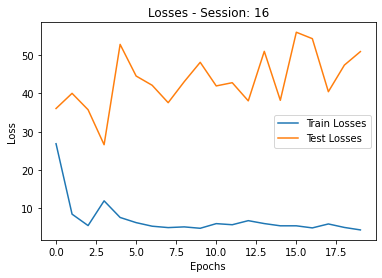

Epoch: 0, Train Loss: 64.7819103, Test Loss: 59.3332809
Epoch: 1, Train Loss: 45.1055057, Test Loss: 57.6563692
Epoch: 2, Train Loss: 38.0248452, Test Loss: 72.0399076
Epoch: 3, Train Loss: 27.9920865, Test Loss: 82.3449687
Epoch: 4, Train Loss: 20.3796885, Test Loss: 76.2128945
Epoch: 5, Train Loss: 16.4387687, Test Loss: 90.9756036
Epoch: 6, Train Loss: 12.2771936, Test Loss: 71.5964388
Epoch: 7, Train Loss: 9.6356488, Test Loss: 50.6622337
Epoch: 8, Train Loss: 9.1082180, Test Loss: 60.8150503
Epoch: 9, Train Loss: 9.0471618, Test Loss: 87.2995481
Epoch: 10, Train Loss: 8.8508364, Test Loss: 49.2578558
Epoch: 11, Train Loss: 9.6467711, Test Loss: 63.7192997
Epoch: 12, Train Loss: 9.4011796, Test Loss: 55.0928824
Epoch: 13, Train Loss: 8.3763321, Test Loss: 62.1217597
Epoch: 14, Train Loss: 8.6220563, Test Loss: 68.7997405
Epoch: 15, Train Loss: 8.0352443, Test Loss: 104.2138820
Epoch: 16, Train Loss: 8.2730586, Test Loss: 62.1378480
Epoch: 17, Train Loss: 8.3697457, Test Loss: 89.38

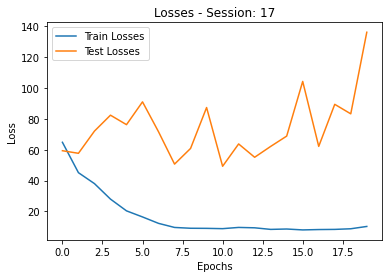

Epoch: 0, Train Loss: 33.4365120, Test Loss: 37.5024413
Epoch: 1, Train Loss: 17.0795360, Test Loss: 29.3901578
Epoch: 2, Train Loss: 14.2498699, Test Loss: 58.5130167
Epoch: 3, Train Loss: 13.4528698, Test Loss: 34.4690923
Epoch: 4, Train Loss: 12.9902190, Test Loss: 33.6427881
Epoch: 5, Train Loss: 12.5071146, Test Loss: 34.9221766
Epoch: 6, Train Loss: 13.0023145, Test Loss: 62.9441887
Epoch: 7, Train Loss: 12.4072104, Test Loss: 33.5623277
Epoch: 8, Train Loss: 11.5029515, Test Loss: 42.2545776
Epoch: 9, Train Loss: 14.6179985, Test Loss: 31.1135881
Epoch: 10, Train Loss: 12.7021013, Test Loss: 31.5907515
Epoch: 11, Train Loss: 11.6003031, Test Loss: 33.3012375
Epoch: 12, Train Loss: 11.0020888, Test Loss: 31.6625954
Epoch: 13, Train Loss: 12.6856637, Test Loss: 32.3168989
Epoch: 14, Train Loss: 13.0281891, Test Loss: 29.2453561
Epoch: 15, Train Loss: 11.9268996, Test Loss: 43.6068158
Epoch: 16, Train Loss: 14.4898328, Test Loss: 34.6716545
Epoch: 17, Train Loss: 13.8679806, Test L

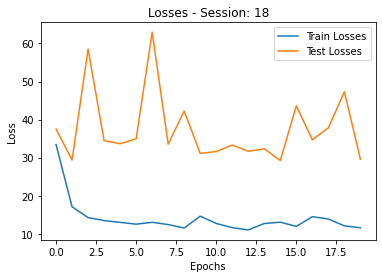

Epoch: 0, Train Loss: 57.6968087, Test Loss: 42.8328291
Epoch: 1, Train Loss: 44.2656494, Test Loss: 44.9997279
Epoch: 2, Train Loss: 39.5753744, Test Loss: 46.2528988
Epoch: 3, Train Loss: 33.8566903, Test Loss: 46.1128975
Epoch: 4, Train Loss: 25.7268972, Test Loss: 62.6444063
Epoch: 5, Train Loss: 20.9893814, Test Loss: 61.7849074
Epoch: 6, Train Loss: 17.2639936, Test Loss: 58.8476128
Epoch: 7, Train Loss: 14.5366740, Test Loss: 57.4614927
Epoch: 8, Train Loss: 12.8829764, Test Loss: 73.9013898
Epoch: 9, Train Loss: 13.2127613, Test Loss: 75.5720006
Epoch: 10, Train Loss: 11.0719487, Test Loss: 53.3560931
Epoch: 11, Train Loss: 10.5143556, Test Loss: 79.9634670
Epoch: 12, Train Loss: 10.6282739, Test Loss: 64.9207289
Epoch: 13, Train Loss: 9.4140606, Test Loss: 52.3756970
Epoch: 14, Train Loss: 9.5372604, Test Loss: 60.7221872
Epoch: 15, Train Loss: 10.6361386, Test Loss: 50.4389681
Epoch: 16, Train Loss: 12.1401616, Test Loss: 124.0320395
Epoch: 17, Train Loss: 9.5737295, Test Los

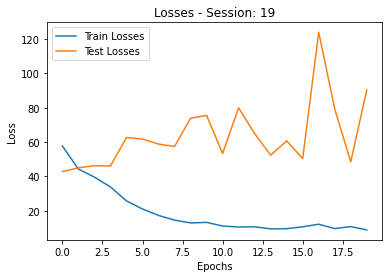

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, (train_dataset, test_dataset) in enumerate(zip(train_dataset_list,test_dataset_list)):
    hidden_dim = 256
    max_timestamps = sessions_dataset_list[i].max_timestamps
    encoder = EncoderRNN(19, hidden_dim, num_layers = 1).to(device)
    decoder = DecoderRNN(hidden_dim, neuraloutputs_shapes_list[i], num_layers = 1).to(device)
    num_epochs = 20
    
    epoch_train_losses, epoch_test_losses, encoder_state_dicts, decoder_state_dicts = \
        traintestIters(encoder, decoder, num_epochs, train_dataset, test_dataset, max_timestamps)
    
    best_encoder = encoder_state_dicts[np.argmin(np.array(epoch_train_losses))]
    best_decoder = decoder_state_dicts[np.argmin(np.array(epoch_train_losses))]

    plt.plot(epoch_train_losses)
    plt.plot(epoch_test_losses)
    plt.title('Losses - Session: {}'.format(i+16))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Losses', 'Test Losses'])
    plt.show()

    # save model
    directory = '/content/drive/My Drive/Miller_Lab/FIU/Encoder_Decoder_RNN/'
    encoder_model_name = 'session{}_encoder.pth'.format(i+16)
    decoder_model_name = 'session{}_decoder.pth'.format(i+16)
    torch.save(best_encoder, directory+encoder_model_name)
    torch.save(best_decoder, directory+decoder_model_name)

# Load Models

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoders_list = []
decoders_list = []
path = '/content/drive/My Drive/Miller_Lab/FIU/Encoder_Decoder_RNN/'

for i, filename in enumerate(os.listdir(path)):
    j = int(i/2)
    f = os.path.join(path,filename)
    if 'encoder' in filename:
        enc = EncoderRNN(19, 256, num_layers = 1).to(device)
        enc.load_state_dict(torch.load(f, map_location=torch.device('cpu')))
        encoders_list.append(enc)
    else:
        dec = DecoderRNN(256, neuraloutputs_shapes_list[j], num_layers = 1).to(device)
        dec.load_state_dict(torch.load(f, map_location=torch.device('cpu')))
        decoders_list.append(dec)

In [26]:
len(encoders_list), len(decoders_list)

(4, 4)

In [27]:
for s, (encoder, decoder) in enumerate(zip(encoders_list, decoders_list)):
    train_decoder_output_list_all, train_targets_all, test_decoder_output_list_all, test_targets_all = \
          get_predictions(encoder, decoder, train_dataset_list[s], test_dataset_list[s], sessions_dataset_list[s].max_timestamps)

    # do pca on each element in predictions, targets
    fig, ax = plt.subplots(nrows = 32, ncols = 4)
    fig.set_size_inches(20, 180)
    for i, (pred, targ) in enumerate(zip(train_decoder_output_list_all, train_targets_all)):
        j, k = divmod(i,4)
        pca_preds = PCA(n_components=2)
        pca_targets = PCA(n_components=2)

        pca_preds_features = pca_preds.fit_transform(pred)
        pca_target_features = pca_targets.fit_transform(targ)
        
        pca_preds_var = pca_preds.explained_variance_ratio_
        pca_target_var = pca_targets.explained_variance_ratio_

        pca1_preds_var, pca2_preds_var = round(pca_preds_var[0],4), round(pca_preds_var[1],4)
        pca1_targets_var, pca2_targets_var = round(pca_target_var[0],4), round(pca_target_var[1],4)

        # print('Preds Variance PC1: {}, Preds Variance PC2: {}'.format(pca1_preds_var, pca2_preds_var))
        # print('Target Variance PC1: {}, Target Variance PC2: {}'.format(pca1_targets_var, pca2_targets_var))

        ax[j][k].scatter(pca_target_features[:,0], pca_target_features[:,1], label='Targets')
        ax[j][k].scatter(pca_preds_features[:,0], pca_preds_features[:,1], label='Preds')

        ax[j][k].set_xlabel('PC1')
        ax[j][k].set_ylabel('PC2')

        ax[j][k].set_title('PCA Plots Session {}, Trial {}'.format(s+16,i))

        ax[j][k].legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [32]:
for s, (encoder, decoder) in enumerate(zip(encoders_list, decoders_list)):
    train_decoder_output_list_all, train_targets_all, test_decoder_output_list_all, test_targets_all = \
          get_predictions(encoder, decoder, train_dataset_list[s], test_dataset_list[s], sessions_dataset_list[s].max_timestamps)

    train_decoder_output_array_all = np.vstack(train_decoder_output_list_all)
    train_targets_array_all = np.vstack(train_targets_all)
    test_decoder_output_array_all = np.vstack(test_decoder_output_list_all)
    test_targets_array_all = np.vstack(test_targets_all)

    r2_train = sklearn.metrics.r2_score(train_decoder_output_array_all,train_targets_array_all)
    r2_test = sklearn.metrics.r2_score(test_decoder_output_array_all,test_targets_array_all)

    print('Session {}'.format(s+16))
    print('Train r^2 = {}'.format(r2_train))
    print('Test r^2 = {}'.format(r2_test))
    print('\n')

Session 16
Train r^2 = -148.51984903054142
Test r^2 = -89.35597928710824


Session 17
Train r^2 = -172.65130488734178
Test r^2 = -198.81340924410748


Session 18
Train r^2 = -136.0154956543071
Test r^2 = -173.94258006560244


Session 19
Train r^2 = -108.11068177138829
Test r^2 = -174.40390179814707




In [ ]:
len(train_decoder_output_list_all), len(train_targets_all), len(test_decoder_output_list_all), len(test_targets_all)

(128, 128, 32, 32)

In [ ]:
train_decoder_output_list_all[0].shape, train_targets_all[0].shape, test_decoder_output_list_all[0].shape, test_targets_all[0].shape

((857, 54), (857, 54), (857, 54), (857, 54))

In [ ]:
train_decoder_output_arr_all = np.vstack(train_decoder_output_list_all)
train_targets_arr_all = np.vstack(train_targets_all)

test_decoder_output_arr_all = np.vstack(test_decoder_output_list_all)
test_targets_arr_all = np.vstack(test_targets_all)

In [ ]:
print(sklearn.metrics.r2_score(train_decoder_output_arr_all,train_targets_arr_all, multioutput='variance_weighted'))

-320799.467676709


In [ ]:
print(sklearn.metrics.r2_score(test_decoder_output_arr_all,test_targets_arr_all, multioutput='variance_weighted'))

-364785.51500190323


In [ ]:
train_decoder_output_list_all[0].shape

(857, 54)

In [ ]:
for i in range(857):
    

In [ ]:
x = []
for i in range(len(train_decoder_output_list_all)):
    score = sklearn.metrics.r2_score(train_decoder_output_list_all[i],train_targets_all[i])
    x.append(score)

In [ ]:
sum(x)

-70258.8366685722

In [ ]:
# Histogram, Boxplot, and PCA - Error Visualization
for j in range(4): #iterate through sessions
    for i in range(4): #iterate through models
        pca_features = [train_pca_features[j], val_pca_features[j], test_pca_features[j]]
        labels = ['Train', 'Val', 'Test']
        fig, ax = plt.subplots(nrows = 4, ncols = 3)
        fig.set_size_inches(20, 20)
        instance_losses = all_instance_data[j][i]
        for k in range(3):
            ax[0][k].hist(instance_losses[k][0], bins = 300, label = labels[k])
            ax[0][k].set_title('Error Distribution - Session: {}, Model: {}, Layers: {}'.format(j+16, i, i+3))
            ax[0][k].legend()

            ax[1][k].boxplot(instance_losses[k][0], vert = False)
            ax[1][k].set_title('Error Boxplot - Session: {}, Model: {}, Layers: {}'.format(j+16, i, i+3))

            ax[2][k].boxplot(instance_losses[k][0], vert = False, showfliers=False)
            ax[2][k].set_title('Error Boxplot - Session: {}, Model: {}, Layers: {}'.format(j+16, i, i+3))

            # reorder pca features so highest losses occur on top
            r = instance_losses[k][0].reshape(instance_losses[k][0].shape[0], 1)
            data = np.concatenate((pca_features[k],r), axis=1)
            data_sorted = data[data[:, 2].argsort()]

            ax[3][k].scatter(data_sorted[:,0], data_sorted[:,1], c=data_sorted[:,2], cmap='jet', label = labels[k])
            ax[3][k].set_xlabel('PC1')
            ax[3][k].set_ylabel('PC2')
            ax[3][k].set_title('Neural Output PCA - Session: {}, Model: {}, Layers: {}'.format(j+16, i, i+3))
            ax[3][k].legend()
        plt.show()

In [ ]:
# get the top 100 losses for each session

for j, session_dataset in enumerate(sessions_dataset_list): #iterate through sessions
    num_instances = len(session_dataset)
    train_split = int(num_instances*.6)
    val_split = int(num_instances*.2)

    for i in range(4): # iterate through models
        labels = ['Train', 'Val', 'Test']
        instance_data = all_instance_data[j][i]
        for k in range(3): #plot train, val, test data
            # reorder pca features so highest losses occur on top
            print(instance_data[k][0].shape, instance_data[k][1].shape, instance_data[k][2].shape, instance_data[k][3].shape, instance_data[k][4].shape)
            instance_losses = instance_data[k][0].reshape(instance_data[k][0].shape[0], 1)
            instance_inputs = instance_data[k][1]
            instance_targets = instance_data[k][2]
            instance_samplenums = instance_data[k][3].reshape(instance_data[k][3].shape[0], 1)
            instance_trialnums = instance_data[k][4].reshape(instance_data[k][4].shape[0], 1)
            session_num = instance_data[k][5]

            instance_losses_r = instance_losses.reshape(instance_losses.shape[0], 1)
            instance_samplenums_r = instance_samplenums.reshape(instance_samplenums.shape[0], 1)
            instance_trialnums_r = instance_trialnums.reshape(instance_trialnums.shape[0], 1)

            data = np.concatenate((instance_losses_r, instance_samplenums_r, instance_trialnums_r), axis=1)
            top_100_losses = data[data[:, 0].argsort()[::-1]][:100,:]

            print('Top 100 losses for Session {}, Model {}, {} Dataset'.format(session_num, i, labels[k]))
            for l in range(len(top_100_losses)):
              print('Loss Value: {}, Trial Num: {}, Sample Num: {}'\
                      .format(top_100_losses[l][0], top_100_losses[l][1], top_100_losses[l][2]))
                # print('Loss Value: {}, Sample Num: {}, Trial Num: {}'\
                #       .format(top_100_losses[l][0], top_100_losses[l][1], top_100_losses[l][2]))

(6783,) (6783, 19) (6783, 54) (6783,) (6783,)
Top 100 losses for Session 16, Model 0, Train Dataset
Loss Value: 342.5726623535156, Trial Num: 67.0, Sample Num: 5205.0
Loss Value: 285.3747253417969, Trial Num: 94.0, Sample Num: 6796.0
Loss Value: 251.53314208984375, Trial Num: 121.0, Sample Num: 8793.0
Loss Value: 192.21888732910156, Trial Num: 135.0, Sample Num: 9697.0
Loss Value: 150.84017944335938, Trial Num: 145.0, Sample Num: 10312.0
Loss Value: 106.47569274902344, Trial Num: 38.0, Sample Num: 2370.0
Loss Value: 101.79981231689453, Trial Num: 8.0, Sample Num: 640.0
Loss Value: 100.50648498535156, Trial Num: 121.0, Sample Num: 8794.0
Loss Value: 95.27727508544922, Trial Num: 117.0, Sample Num: 8556.0
Loss Value: 92.08778381347656, Trial Num: 71.0, Sample Num: 5414.0
Loss Value: 77.33881378173828, Trial Num: 67.0, Sample Num: 5206.0
Loss Value: 75.14341735839844, Trial Num: 15.0, Sample Num: 1085.0
Loss Value: 74.90441131591797, Trial Num: 151.0, Sample Num: 10708.0
Loss Value: 69.39

# Load Models and plot PCA for glove input

In [ ]:
neuraloutputs_shapes_list_loading = [54,54,54,54,41,41,41,41,45,45,45,45,28,28,28,28]
layers_loading = [3,4,5,6,3,4,5,6,3,4,5,6,3,4,5,6]
loaded_models_list = []
path = '/content/drive/MyDrive/Miller_Lab/FIU/MLP/'
for shape, layers, filename in zip(neuraloutputs_shapes_list_loading, layers_loading, os.listdir(path)):
    f = os.path.join(path,filename)

    loaded_m = FCNet(input_dim = 19, output_dim=shape, num_layers = layers, hidden_layer_dim = 32)
    loaded_m.load_state_dict(torch.load(f))
    loaded_models_list.append(loaded_m)

In [ ]:
loaded_models_array = np.array(loaded_models_list).reshape((4,4), order='C')

In [ ]:
for m in loaded_models_array[0]:
    print(m.num_layers)

3
4
5
6


In [ ]:
all_instance_data = []
for j, (train_loader, val_loader, test_loader, models_list) in enumerate(zip(train_loaders_list, val_loaders_list, test_loaders_list, loaded_models_array)):

    print('Session Number: {}'.format(j+16))

    model_instance_data = []
    for i, model in enumerate(models_list):

        print('Model Number: {}'.format(i))
        print('Num Layers: {}, Hidden Layer Dimensionality: {}'\
            .format(model.num_layers, model.hidden_layer_dim))

        # get the losses for each sample
        instance_data = [get_instance_losses(train_loader, model),\
                                get_instance_losses(val_loader, model),\
                                get_instance_losses(test_loader, model)]
        model_instance_data.append(instance_data)

    all_instance_data.append(model_instance_data)

Session Number: 16
Model Number: 0
Num Layers: 3, Hidden Layer Dimensionality: 32
Model Number: 1
Num Layers: 4, Hidden Layer Dimensionality: 32
Model Number: 2
Num Layers: 5, Hidden Layer Dimensionality: 32
Model Number: 3
Num Layers: 6, Hidden Layer Dimensionality: 32
Session Number: 17
Model Number: 0
Num Layers: 3, Hidden Layer Dimensionality: 32
Model Number: 1
Num Layers: 4, Hidden Layer Dimensionality: 32
Model Number: 2
Num Layers: 5, Hidden Layer Dimensionality: 32
Model Number: 3
Num Layers: 6, Hidden Layer Dimensionality: 32
Session Number: 18
Model Number: 0
Num Layers: 3, Hidden Layer Dimensionality: 32
Model Number: 1
Num Layers: 4, Hidden Layer Dimensionality: 32
Model Number: 2
Num Layers: 5, Hidden Layer Dimensionality: 32
Model Number: 3
Num Layers: 6, Hidden Layer Dimensionality: 32
Session Number: 19
Model Number: 0
Num Layers: 3, Hidden Layer Dimensionality: 32
Model Number: 1
Num Layers: 4, Hidden Layer Dimensionality: 32
Model Number: 2
Num Layers: 5, Hidden Laye

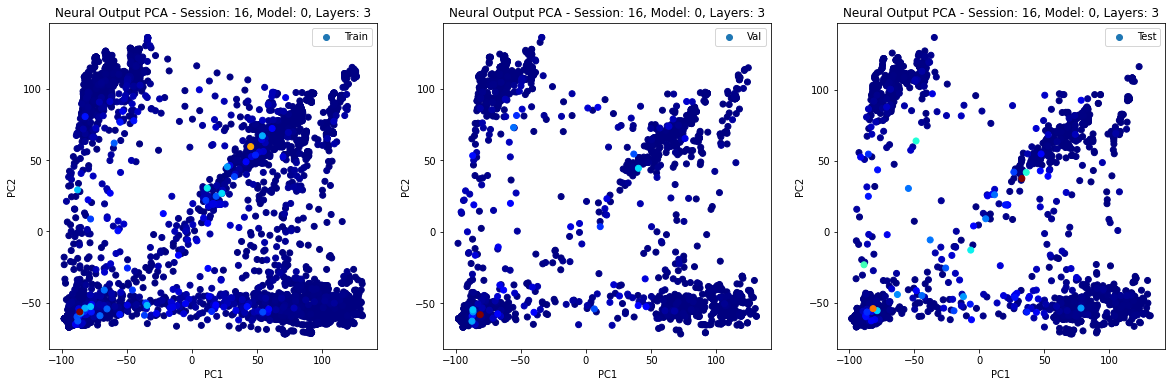

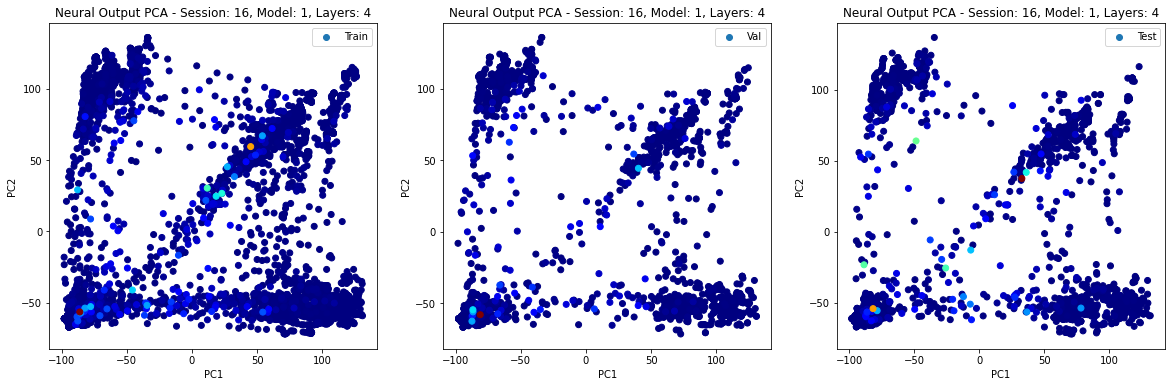

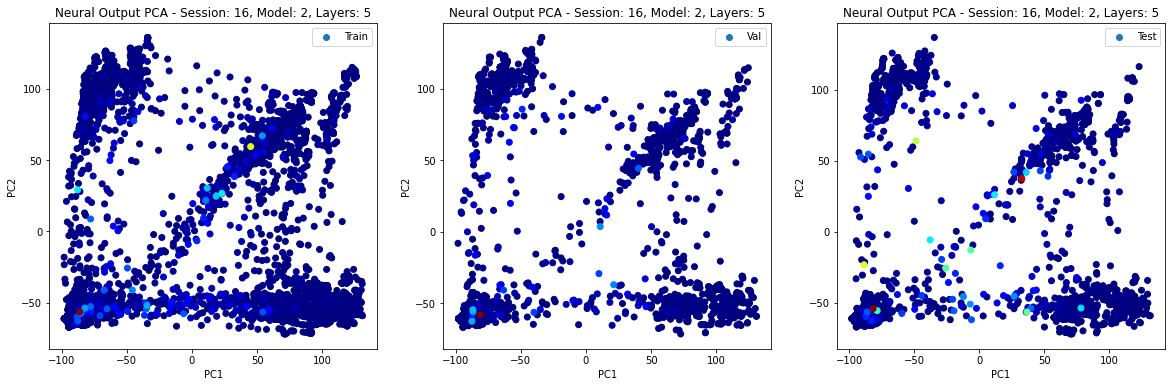

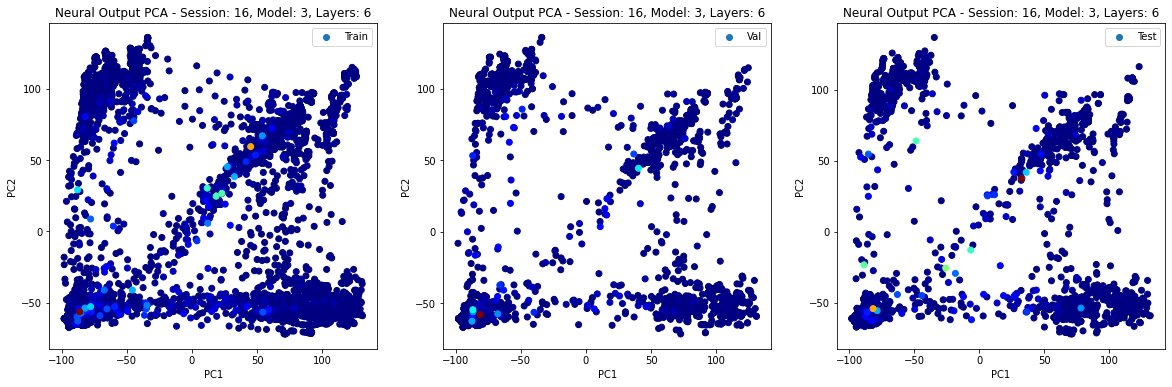

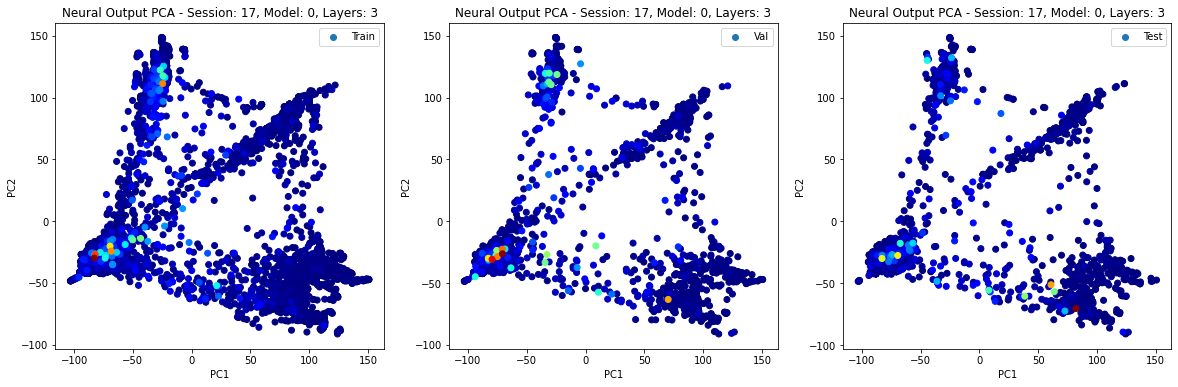

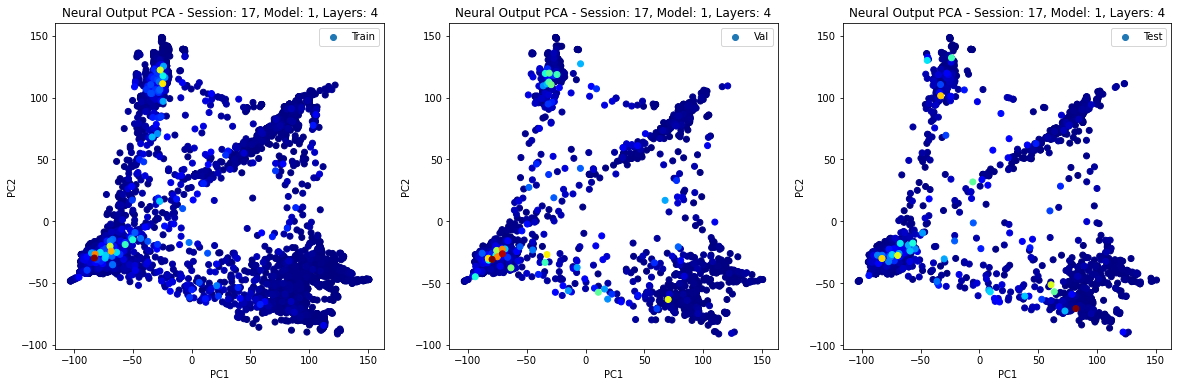

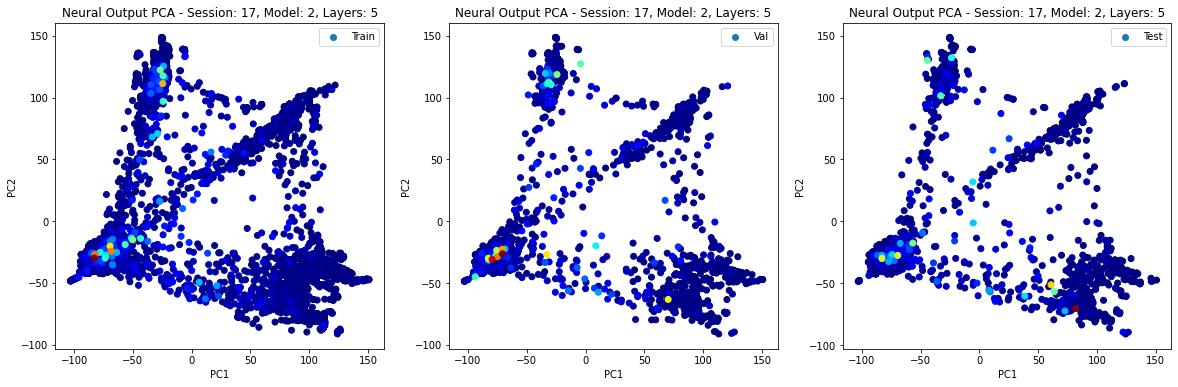

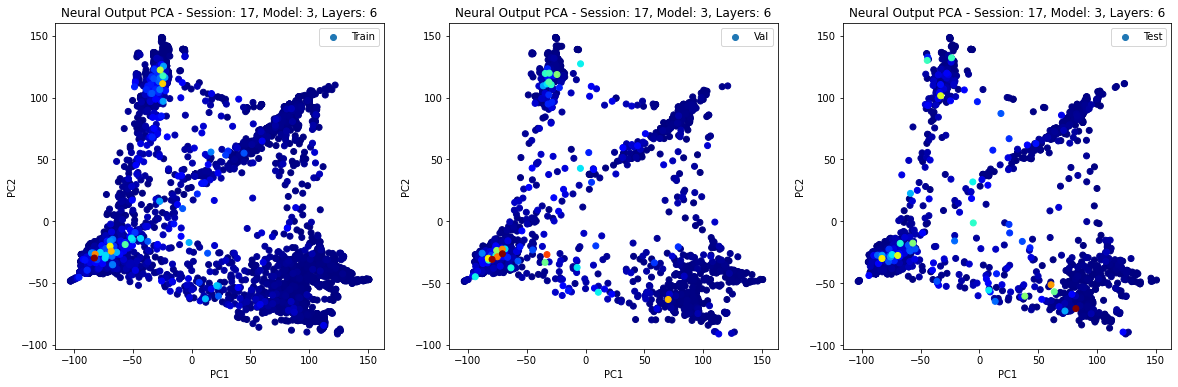

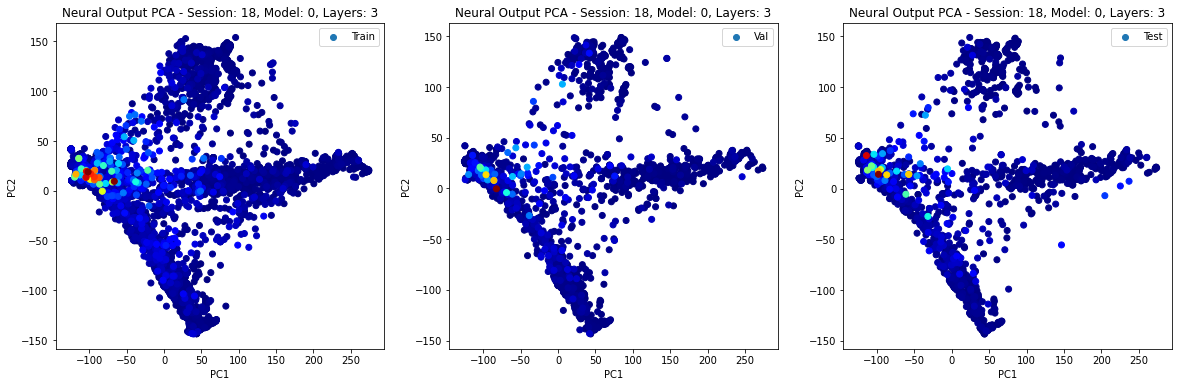

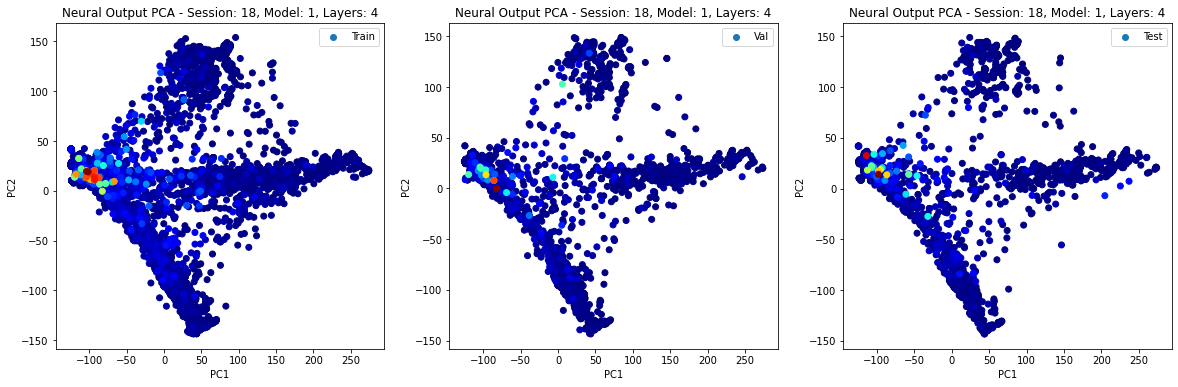

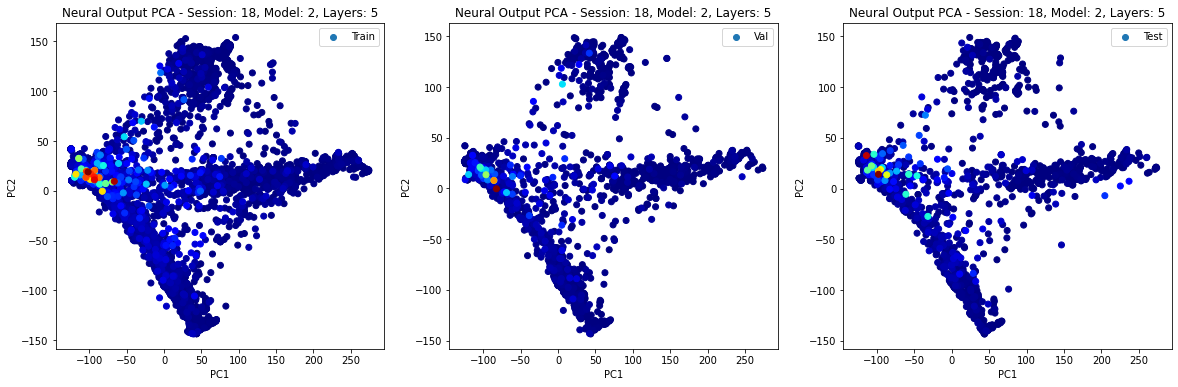

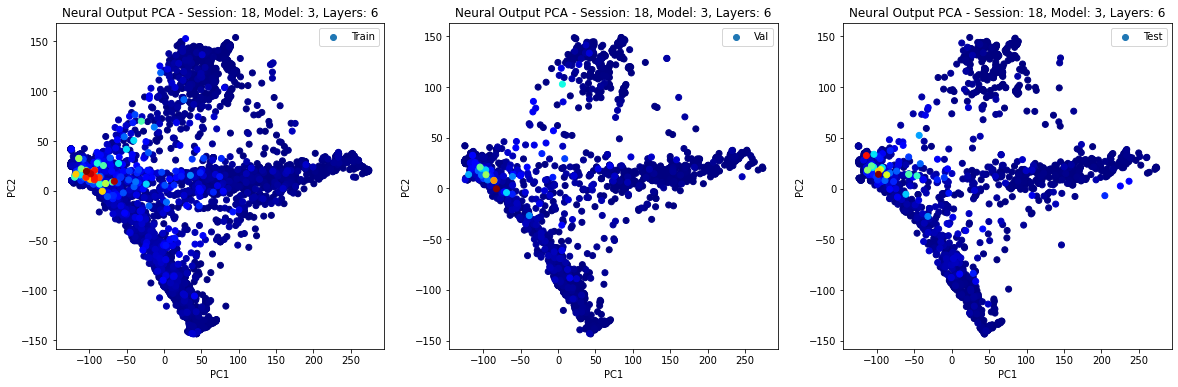

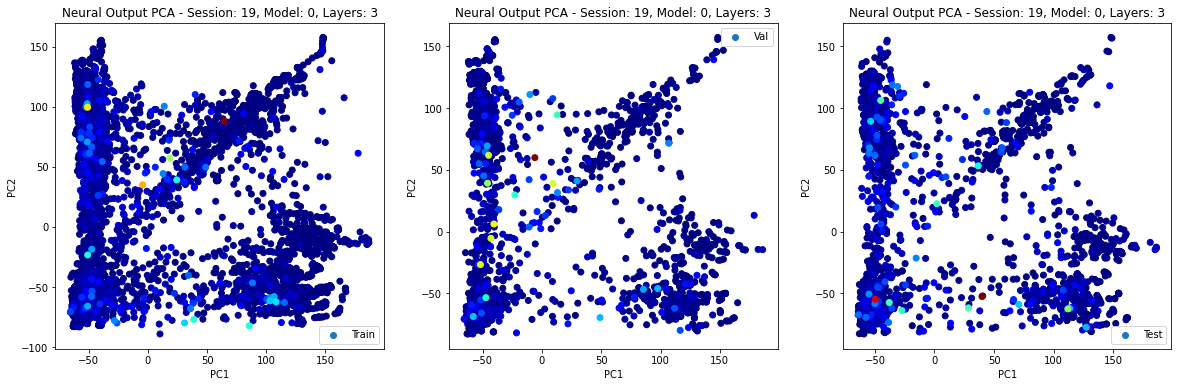

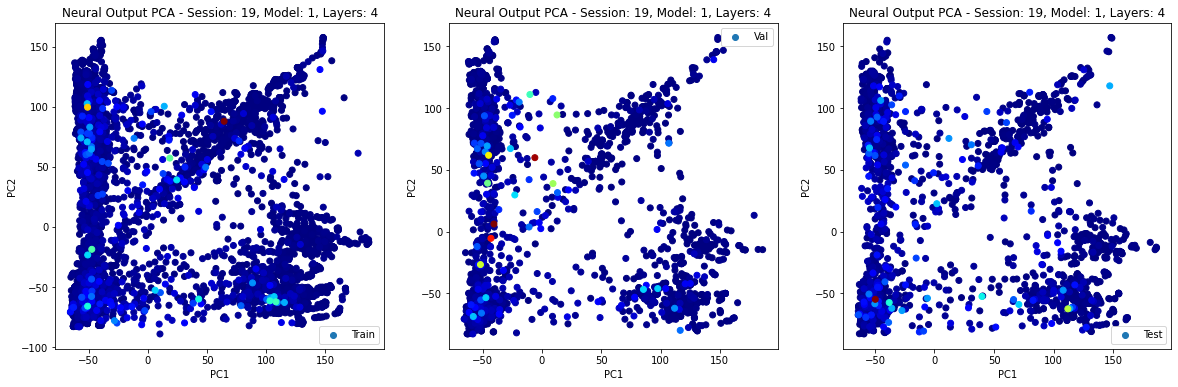

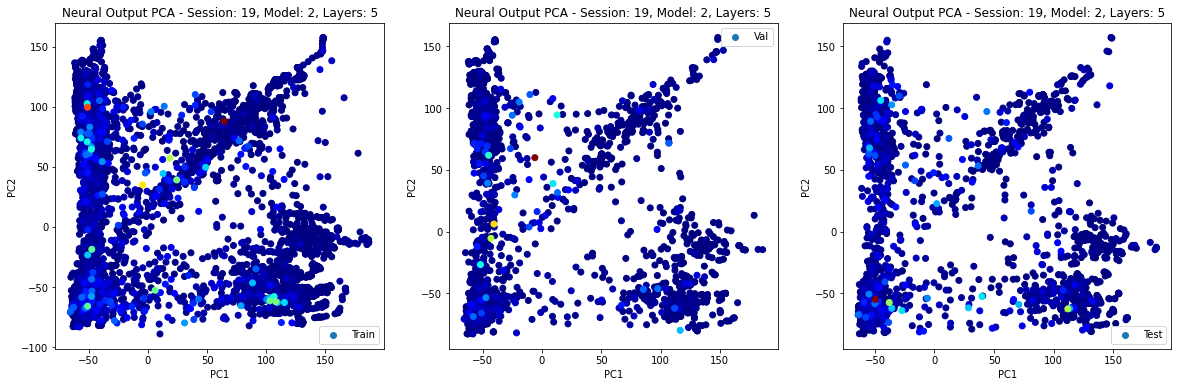

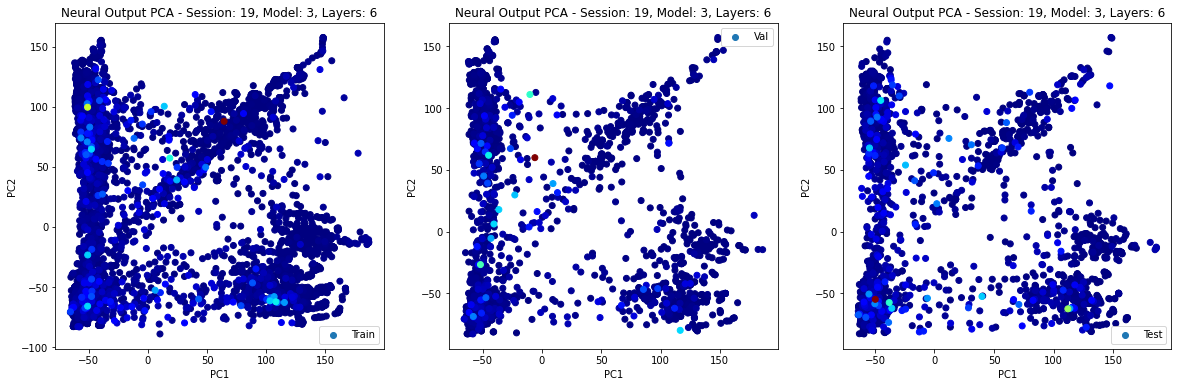

In [ ]:
# Histogram, Boxplot, and PCA - Error Visualization
for j in range(4): #iterate through sessions
    for i in range(4): #iterate through models
        pca_glove_features = [train_pca_glove_features[j], val_pca_glove_features[j], test_pca_glove_features[j]]
        labels = ['Train', 'Val', 'Test']
        fig, ax = plt.subplots(nrows = 1, ncols = 3)
        fig.set_size_inches(20, 6)
        instance_losses = all_instance_data[j][i]
        for k in range(3):

            # reorder pca features so highest losses occur on top
            r = instance_losses[k][0].reshape(instance_losses[k][0].shape[0], 1)
            data = np.concatenate((pca_glove_features[k],r), axis=1)
            data_sorted = data[data[:, 2].argsort()]

            ax[k].scatter(data_sorted[:,0], data_sorted[:,1], c=data_sorted[:,2], cmap='jet', label = labels[k])
            ax[k].set_xlabel('PC1')
            ax[k].set_ylabel('PC2')
            ax[k].set_title('Neural Output PCA - Session: {}, Model: {}, Layers: {}'.format(j+16, i, i+3))
            ax[k].legend()

        plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first = True)

    def forward(self, input, hidden):
        embedded = self.embedding(input) #shape = batch size, seq length, embedding dim
        output, (hidden,cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input) #shape = batch size, seq length, embedding dim
        output, (hidden,cell) = self.rnn(embedded)
        pred = self.fc(output)
        return pred, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, source, target, teacher_force_ratio = 0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, self.decoder.output_size).to(device)

        hidden, cell = self.encoder(source)
        x = target[:,0,:]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:,t,:] = output

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=19):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

  